### Mount Google Drive

In [19]:
# # mount your current Google Drive (Directory)
import os
from google.colab import drive         

base_path = '/content/drive'
drive.mount(base_path, force_remount=True)
file = 'My Drive/고영 (5차년도)/model/np/MOM4_data.csv'
data_path = os.path.join(base_path, file)    # colab

# uncomment for local
# data_path = os.path.join('./np/',file)    # local
# prepare directories for results
result_path = os.path.join(base_path,'My Drive/고영 (5차년도)/model/np/1d_regression_MOM4')
if not os.path.isdir(result_path):
    os.makedirs(result_path)

Mounted at /content/drive


### Import packages

In [20]:
'''
Common
'''

# imports
import shutil
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Read in dataset

In [21]:
'''
Read dataset
'''

# configurations for plots
%matplotlib inline
pd.set_option('display.max_columns', None)

# read data
df = pd.read_csv(data_path  ,index_col=False).drop(['Unnamed: 0'], axis=1)
df.reset_index(drop=True, inplace=True)
assert df.isnull().sum().sum() == 0
temp = df.copy()
df.head(5)

,CRD,PartType,Orient.,X,Y,SPI_VOLUME1,SPI_VOLUME2,SPI_X1,SPI_Y1,SPI_X2,SPI_Y2,SPI_L1,SPI_W1,SPI_L2,SPI_W2,SPI_L,SPI_W,PRE_X,PRE_Y,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_R,PRE_R,POST_R,SPI_VOLUME_MEAN,SPI_VOLUME_DIFF
0,B1,R0402,90,31.26,100.11,81.7355,75.6950,-51.9,63.3,-52.1,60.5,63.3,51.9,60.5,52.1,61.90,52.0,-19.887293,-1.840963,-1.877,-1.840963,19.887293,-7.440417,28.108231,1.613,28.108231,7.440417,CENTER,400.0,200.0,80.843120,19.972320,29.076321,78.71525,6.0405
1,B2,R0402,90,31.83,100.11,83.1555,71.5083,-45.7,66.1,-48.3,61.3,66.1,45.7,61.3,48.3,63.70,47.0,-26.766272,6.898049,-1.449,6.898049,26.766272,5.487133,22.242701,0.000,22.242701,-5.487133,CENTER,400.0,200.0,79.162428,27.640847,22.909526,77.33190,11.6472
2,B3,R0402,90,32.40,100.11,87.0870,67.2606,-48.6,75.8,-34.6,68.9,75.8,48.6,68.9,34.6,72.35,41.6,-32.058273,8.125244,-3.278,8.125244,32.058273,-19.644203,12.971593,1.552,12.971593,19.644203,CENTER,400.0,200.0,83.457070,33.071929,23.540538,77.17380,19.8264
3,B4,R0402,90,32.97,100.11,80.0433,75.8866,-56.3,65.8,-44.9,60.4,65.8,56.3,60.4,44.9,63.10,50.6,-23.437572,-6.195457,-3.337,-6.195457,23.437572,-22.517658,26.396389,0.000,26.396389,22.517658,CENTER,400.0,200.0,80.882446,24.242596,34.696027,77.96495,4.1567
4,B5,R0402,90,33.54,100.11,76.7088,74.0452,-48.9,69.7,-51.1,69.2,69.7,48.9,69.2,51.1,69.45,50.0,-5.187286,7.085744,-3.408,7.085744,5.187286,-21.413681,29.193306,3.611,29.193306,21.413681,CENTER,400.0,200.0,85.576296,8.781555,36.204901,75.37700,2.6636


### Visualize entire PCB board

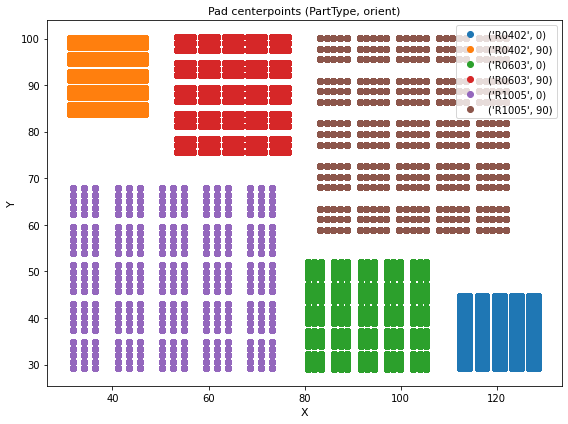

In [22]:
# preprocess by crd and job type
group_indices = {}

dfgroups = df.groupby(['PartType','Orient.'])
fig, ax = plt.subplots(figsize=(8,6))
for name, group in dfgroups:
  # name = (name[0][1:], name[1]) # remove R
  ax.plot(group.X, group.Y, marker='o', linestyle='', label=name)
  group_indices[name] = group.index
  
  # visualize each chip block
  # fig2, ax2 = plt.subplots(figsize=(12,8))
  # ax2.scatter(group.X, group.Y, marker='o', label=name)
  # ax2.set_xlim(xmin=min(group.X)-2, xmax=max(group.X)+2)
  # ax2.set_ylim(ymin=min(group.Y)-2, ymax=max(group.Y)+2)
  # ax2.legend(fontsize=10, loc='upper left')
  # plt.tight_layout()

ax.legend(fontsize=10, loc='upper right')
ax.set_title('Pad centerpoints (PartType, orient)', fontsize=11)
ax.set_xlabel('X', fontsize=11)
ax.set_ylabel('Y', fontsize=11)
plt.tight_layout()
plt.show()

In [23]:
''' CRD: checking how many rows are in each B,C,D chip type '''
df2 = df.copy()
crds = list(df2['CRD'].values)
filter_by_chip = lambda x: [crd for crd in crds if crd[0] == x]
crds_0402 = filter_by_chip('B')
crds_0603 = filter_by_chip('C')
crds_1005 = filter_by_chip('D')
print(f'B: {len(crds_0402)}, C: {len(crds_0603)}, D: {len(crds_1005)}')


B: 60750, C: 60749, D: 60748


### Define chip part type, X and Y features (e.g. *PRE_L*, *POST_L*)
- How do the distributions look?

In [24]:
''' 
preprocessing
    chip_dataframes contains grouped data by part type
    in a dictionary with each part type as the key
'''
# 1. group into chip placement types
chip_dataframes = dict()
for name, group in df2.groupby(['PartType']):
    chip_dataframes[str(name)] = group
# 2. select by part type, xvar, yvar
parttype = 'R1005' # ['R0402', 'R0608', 'R1005']
xvar = 'PRE_W'
yvar = 'POST_W'
data = chip_dataframes[parttype]

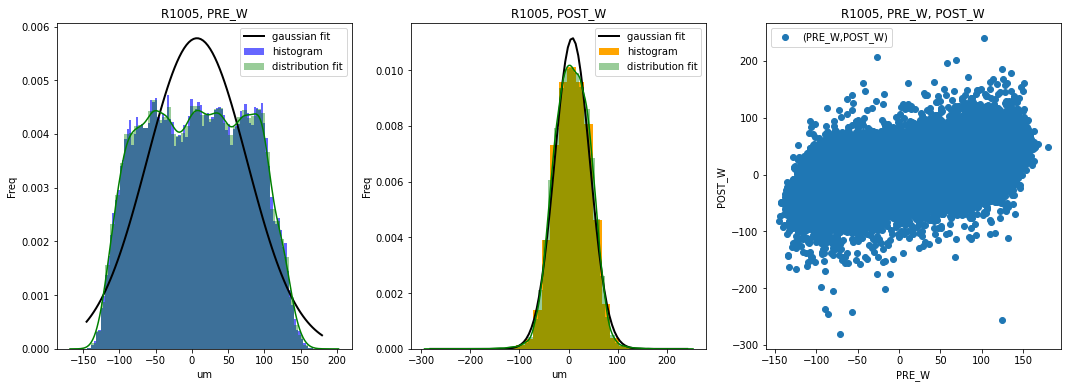

In [25]:
from scipy.stats import norm
# suppress future warning for 'distplot' in seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig = plt.figure(figsize=(18,6))

''' xvar '''
ax = fig.add_subplot(131)
# actual histogram
ax.hist(data[xvar], bins=100, density=True, alpha=0.6, color='b', label="histogram")
# gaussian fitting
mu, std = norm.fit(data[xvar])
x = np.linspace(np.min(data[xvar]), np.max(data[xvar]), 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2, label="gaussian fit")
# distribution envelope tracing
sns.distplot(data[xvar], color='g', label="distribution fit", ax=ax)
ax.set_title(f'{parttype}, {xvar}')
ax.set_xlabel("um")
ax.set_ylabel("Freq")
ax.legend(loc='best')
# plt.show()

''' yvar '''
ax2 = fig.add_subplot(132)
# actual histogram
ax2.hist(data[yvar], bins=30, density=True, alpha=1, color='orange', label="histogram")
# gaussian fitting
mu, std = norm.fit(data[yvar])
x = np.linspace(np.min(data[yvar]), np.max(data[yvar]), 100)
p = norm.pdf(x, mu, std)
ax2.plot(x, p, 'k', linewidth=2, label="gaussian fit")
# distribution envelope tracing
sns.distplot(data[yvar], color='g', label="distribution fit", ax=ax2)
ax2.set_title(f'{parttype}, {yvar}')
ax2.set_xlabel("um")
ax2.set_ylabel("Freq")
ax2.legend(loc='best')
# plt.show()

''' 2-D view altogether '''
ax3 = fig.add_subplot(133)
all_x_np = data[xvar].values[0:-1].reshape(-1, 1).astype(np.float32)
all_y_np = data[yvar].values[0:-1].reshape(-1, 1).astype(np.float32)
# plot points
ax3.scatter(all_x_np, all_y_np, label=f'({xvar},{yvar})')
ax3.set_title(f'{parttype}, {xvar}, {yvar}')
ax3.legend(loc='best')
ax3.set_xlabel(xvar)
ax3.set_ylabel(yvar)

plt.show()

### NP: 1 dimensional regression

In [26]:
# utility functions
def log_likelihood(mu, std, target):
    norm = torch.distributions.Normal(mu, std)
    return norm.log_prob(target).sum(dim=0).mean()

def KLD_gaussian(mu_q, std_q, mu_p, std_p):
    var_p = std_p**2 + 1e-10
    var_q = std_q**2 + 1e-10
    return (var_q/var_p + ( (mu_q-mu_p)**2) / var_p + torch.log(var_p/var_q) - 1.0).sum() * 0.5

def random_split_context_target(x, y, n_context):
    ind = np.arange(x.shape[0])
    mask = np.random.choice(ind, size=n_context, replace=False)
    return [x[mask], y[mask], np.delete(x, mask, axis=0), np.delete(y, mask, axis=0)]

def visualize(x, y, x_star, model, epoch, xvar='x', yvar='y'):
    r_z = model.data_to_r(x, y)
    z_mu, z_std = model.r_to_z(r_z)
    zsamples = model.reparametrize(z_mu, z_std, 3)
    mu, sigma = model.decoder(x_star, zsamples)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(mu.size(1)):
        ax.plot(x_star.data.cpu().numpy(), mu[:, i].data.cpu().numpy(), linewidth=1)
        ax.fill_between(
            x_grid[:, 0].data.cpu().numpy(), (mu[:, i] - sigma[:, i]).detach().cpu().numpy(),
            (mu[:, i] + sigma[:, i]).detach().cpu().numpy(), alpha=0.2
        )
        ax.scatter(x.data.cpu().numpy(), y.data.cpu().numpy(), color='b')
        # ax.plot(all_x_np, all_y_np, color='b') # plot all points for comparison
        ax.set_xlabel(xvar)
        ax.set_ylabel(yvar)
    # plt.pause(0.0001)
    fig.canvas.draw()
    fig.savefig(os.path.join(result_path, f'{parttype}_{xvar}_{yvar}_epoch_{str(epoch)}.png'))
    plt.show()


np.PNG

In [27]:
# class definition
class NP(nn.Module):
    def __init__(self, hidden_dim, decoder_dim, z_samples):
        super(NP, self).__init__()
        in_dim = 2  
        out_dim = 2 
        self.z_dim = 2
        self.z_samples = z_samples
        # for data (Xc, Yc) --> representation (r)
        self.hidden1 = nn.Linear(in_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, out_dim)
        # for representation (r) --> latent vector (z)
        self.r_to_z_mu = nn.Linear(in_dim, 1)
        self.r_to_z_std = nn.Linear(in_dim, 1)

        self.decoder1 = nn.Linear(in_dim+1, decoder_dim)
        self.decoder2 = nn.Linear(decoder_dim, out_dim)

        nn.init.normal_(self.hidden1.weight)
        nn.init.normal_(self.hidden2.weight)
        nn.init.normal_(self.decoder1.weight)
        nn.init.normal_(self.decoder2.weight)

    # data to representations, aggregated
    def data_to_r(self, x, y):
        x_y = torch.cat([x, y], dim=1)
        hidden1 = self.hidden1(x_y) 
        hidden1_activated = F.relu(hidden1)
        r_i = self.hidden2(hidden1_activated)

        # mean aggregate
        r = r_i.mean(dim=0)
        return r

    # representation to latent vector
    def r_to_z(self, r):
        mean = self.r_to_z_mu(r)
        log_var = self.r_to_z_std(r)
        return mean, F.softplus(log_var)

    # reparam trick for tractability in randomness in the input
    def reparametrize(self, mu, std, n):
        eps = torch.autograd.Variable(std.data.new(n, self.z_dim).normal_())
        z = eps.mul(std).add_(mu)
        return z

    # decoder
    def decoder(self, x_pred, z):
        z = z.unsqueeze(-1).expand(z.size(0), z.size(1), x_pred.size(0)).transpose(1, 2)
        x_pred = x_pred.unsqueeze(0).expand(z.size(0), x_pred.size(0), x_pred.size(1))
        x_z = torch.cat([x_pred, z], dim=-1)

        decoded1 = self.decoder1(x_z).squeeze(-1).transpose(0, 1)
        decoder1_activated = torch.sigmoid(decoded1)
        decoded2 = self.decoder2(decoder1_activated)

        mu, logstd = torch.split(decoded2, 1, dim=-1)
        mu = mu.squeeze(-1)
        logstd = logstd.squeeze(-1)
        std = F.softplus(logstd)
        return mu, std

    def forward(self, x_context, y_context, x_target, y_target):
        # make x, y stack
        x_all = torch.cat([x_context, x_target], dim = 0)
        y_all = torch.cat([y_context, y_target], dim = 0)
        
        # context data -> context repr
        r = self.data_to_r(x_context, y_context)    # data -> repr
        z_mean, z_std = self.r_to_z(r)              # repr -> latent z

        # all data -> global repr
        r_all = self.data_to_r(x_all, y_all)
        z_mean_all, z_std_all = self.r_to_z(r_all)

        # reparameterize
        zs = self.reparametrize(z_mean_all, z_std_all, self.z_samples)

        # decoder
        mu, std = self.decoder(x_context, zs)
        return mu, std, z_mean_all, z_std_all, z_mean, z_std

epoch: 0 loss: 33248770.56


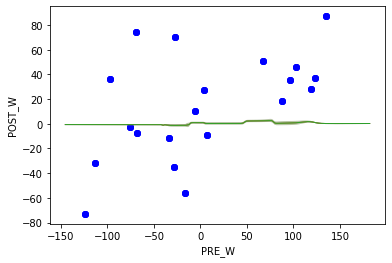

epoch: 1 loss: 3388887203.84
epoch: 2 loss: 6602565877.76
epoch: 3 loss: 5486958018.56
epoch: 4 loss: 3715203072.0
epoch: 5 loss: 2780059074.56
epoch: 6 loss: 3918966947.84
epoch: 7 loss: 564332175.36
epoch: 8 loss: 244434944.0
epoch: 9 loss: 2600125235.2
epoch: 10 loss: 1039348613.12
epoch: 11 loss: 978754273.28
epoch: 12 loss: 637215784.96
epoch: 13 loss: 220251484.16
epoch: 14 loss: 930188247.04
epoch: 15 loss: 4962994421.76
epoch: 16 loss: 3783573176.32
epoch: 17 loss: 30053944.32
epoch: 18 loss: 1207932764.16
epoch: 19 loss: 80255877.12
epoch: 20 loss: 46196444.16
epoch: 21 loss: 457814384.64
epoch: 22 loss: 77018245.12
epoch: 23 loss: 15174182.4
epoch: 24 loss: 1092966563.84
epoch: 25 loss: 1682232279.04
epoch: 26 loss: 2850426388.48
epoch: 27 loss: 35096747.52
epoch: 28 loss: 218110976.0
epoch: 29 loss: 2727981219.84
epoch: 30 loss: 13367402.24
epoch: 31 loss: 161565030.4
epoch: 32 loss: 562981273.6
epoch: 33 loss: 279306670.08
epoch: 34 loss: 79908505.6
epoch: 35 loss: 68853669

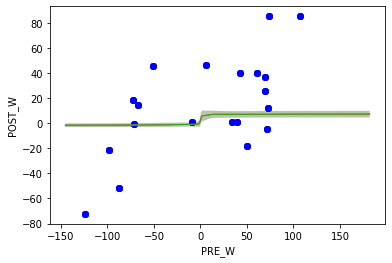

epoch: 1001 loss: 513785.72
epoch: 1002 loss: 294788.42
epoch: 1003 loss: 85003.13
epoch: 1004 loss: 104668.6
epoch: 1005 loss: 1214412.64
epoch: 1006 loss: 867950.96
epoch: 1007 loss: 8888.5425
epoch: 1008 loss: 674673.76
epoch: 1009 loss: 164985.98
epoch: 1010 loss: 1816100.32
epoch: 1011 loss: 118202.05
epoch: 1012 loss: 257917.32
epoch: 1013 loss: 787999.52
epoch: 1014 loss: 43697.545
epoch: 1015 loss: 133218.78
epoch: 1016 loss: 663979.32
epoch: 1017 loss: 4923961.28
epoch: 1018 loss: 7908.070625
epoch: 1019 loss: 169172.22
epoch: 1020 loss: 85818.15
epoch: 1021 loss: 1712461.6
epoch: 1022 loss: 335551.28
epoch: 1023 loss: 176.336640625
epoch: 1024 loss: 51734.96
epoch: 1025 loss: 259305.86
epoch: 1026 loss: 104861.37
epoch: 1027 loss: 61553.87
epoch: 1028 loss: 4204860.8
epoch: 1029 loss: 771072.24
epoch: 1030 loss: 144013.52
epoch: 1031 loss: 31905.3875
epoch: 1032 loss: 123464.55
epoch: 1033 loss: 72905.555
epoch: 1034 loss: 69770.87
epoch: 1035 loss: 498046.68
epoch: 1036 loss

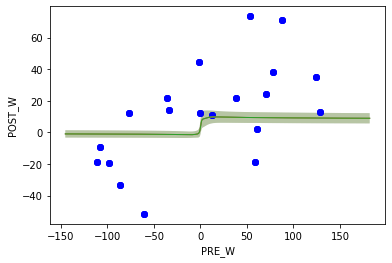

epoch: 2001 loss: 2357.77421875
epoch: 2002 loss: 56330.435
epoch: 2003 loss: 16855.5975
epoch: 2004 loss: 10237.314375
epoch: 2005 loss: 15976.415
epoch: 2006 loss: 2393.3515625
epoch: 2007 loss: 3219.3646875
epoch: 2008 loss: 38.39802734375
epoch: 2009 loss: 42011.92
epoch: 2010 loss: 5697.658125
epoch: 2011 loss: 19700.485
epoch: 2012 loss: 10967.76
epoch: 2013 loss: 8057.53875
epoch: 2014 loss: 80837.42
epoch: 2015 loss: 7211.995625
epoch: 2016 loss: 28106.0625
epoch: 2017 loss: 8349.940625
epoch: 2018 loss: 68476.64
epoch: 2019 loss: 401.769453125
epoch: 2020 loss: 78.6908056640625
epoch: 2021 loss: 22200.9775
epoch: 2022 loss: 5662.159375
epoch: 2023 loss: 1978.75125
epoch: 2024 loss: 7.72327880859375
epoch: 2025 loss: 3624.7471875
epoch: 2026 loss: 13872.35
epoch: 2027 loss: 16575.82875
epoch: 2028 loss: 8221.278125
epoch: 2029 loss: 59771.17
epoch: 2030 loss: 123289.21
epoch: 2031 loss: 2856.526875
epoch: 2032 loss: 20013.82375
epoch: 2033 loss: 3092.3125
epoch: 2034 loss: 4538

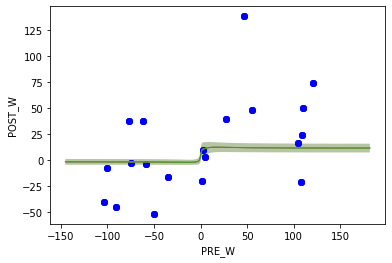

epoch: 3001 loss: 1418.72921875
epoch: 3002 loss: 130.846748046875
epoch: 3003 loss: 635.9242578125
epoch: 3004 loss: 7793.795625
epoch: 3005 loss: 434.5110546875
epoch: 3006 loss: 83.293916015625
epoch: 3007 loss: 2475.63671875
epoch: 3008 loss: 16.57769775390625
epoch: 3009 loss: 3139.230625
epoch: 3010 loss: 125.947998046875
epoch: 3011 loss: 2758.085625
epoch: 3012 loss: 154.666171875
epoch: 3013 loss: 435.4169140625
epoch: 3014 loss: 3034.538125
epoch: 3015 loss: 820.87125
epoch: 3016 loss: 9.459930419921875
epoch: 3017 loss: 3011.416875
epoch: 3018 loss: 9.372720947265625
epoch: 3019 loss: 3868.6409375
epoch: 3020 loss: 6830.133125
epoch: 3021 loss: 416.39328125
epoch: 3022 loss: 405.2334375
epoch: 3023 loss: 1053.733671875
epoch: 3024 loss: 1157.254296875
epoch: 3025 loss: 958.21625
epoch: 3026 loss: 397.1526953125
epoch: 3027 loss: 83.101337890625
epoch: 3028 loss: 44.2377294921875
epoch: 3029 loss: 3707.8934375
epoch: 3030 loss: 1418.19609375
epoch: 3031 loss: 861.12515625
epo

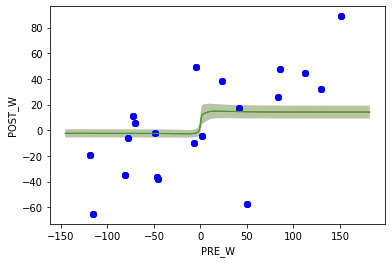

epoch: 4001 loss: 3.4577008056640626
epoch: 4002 loss: 7.350738525390625
epoch: 4003 loss: 79.010263671875
epoch: 4004 loss: 5.14911865234375
epoch: 4005 loss: 6.325819091796875
epoch: 4006 loss: 8.707138671875
epoch: 4007 loss: 16.994027099609376
epoch: 4008 loss: 3.5383056640625
epoch: 4009 loss: 18.419998779296876
epoch: 4010 loss: 3.8781967163085938
epoch: 4011 loss: 5.400204467773437
epoch: 4012 loss: 3.2441812133789063
epoch: 4013 loss: 15.75763671875
epoch: 4014 loss: 5.011151428222656
epoch: 4015 loss: 4.746335754394531
epoch: 4016 loss: 14.762884521484375
epoch: 4017 loss: 37.35403076171875
epoch: 4018 loss: 5.346898803710937
epoch: 4019 loss: 15.13850341796875
epoch: 4020 loss: 5.934611206054687
epoch: 4021 loss: 2.9167965698242186
epoch: 4022 loss: 42.0115087890625
epoch: 4023 loss: 2.0511537170410157
epoch: 4024 loss: 4.575144653320312
epoch: 4025 loss: 3.8245693969726564
epoch: 4026 loss: 20.58689453125
epoch: 4027 loss: 14.17841796875
epoch: 4028 loss: 9.87752685546875
ep

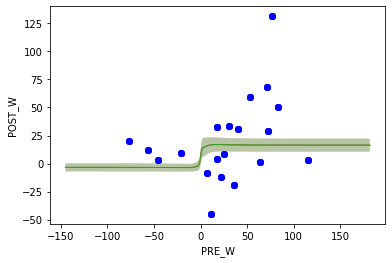

epoch: 5001 loss: 3.028475341796875
epoch: 5002 loss: 2.347384490966797
epoch: 5003 loss: 2.8357119750976563
epoch: 5004 loss: 2.0800384521484374
epoch: 5005 loss: 1.4233926391601563
epoch: 5006 loss: 2.4948956298828127
epoch: 5007 loss: 5.385281372070312
epoch: 5008 loss: 3.7998648071289063
epoch: 5009 loss: 5.985288696289063
epoch: 5010 loss: 3.16748291015625
epoch: 5011 loss: 5.355199584960937
epoch: 5012 loss: 2.6034921264648436
epoch: 5013 loss: 3.4726486206054688
epoch: 5014 loss: 2.2210043334960936
epoch: 5015 loss: 2.777884826660156
epoch: 5016 loss: 3.345736389160156
epoch: 5017 loss: 7.1954541015625
epoch: 5018 loss: 2.280495300292969
epoch: 5019 loss: 2.6202407836914063
epoch: 5020 loss: 2.4858164978027344
epoch: 5021 loss: 2.4615908813476564
epoch: 5022 loss: 3.8960205078125
epoch: 5023 loss: 3.136649475097656
epoch: 5024 loss: 3.91843017578125
epoch: 5025 loss: 3.6277008056640625
epoch: 5026 loss: 1.9777543640136719
epoch: 5027 loss: 2.6643136596679686
epoch: 5028 loss: 3.

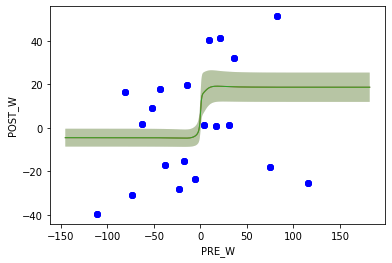

epoch: 6001 loss: 1.6958433532714843
epoch: 6002 loss: 1.7479808044433593
epoch: 6003 loss: 3.0435943603515625
epoch: 6004 loss: 1.4031346130371094
epoch: 6005 loss: 1.217259292602539
epoch: 6006 loss: 2.1262944030761717
epoch: 6007 loss: 3.7948184204101563
epoch: 6008 loss: 1.5610882568359374
epoch: 6009 loss: 1.296755828857422
epoch: 6010 loss: 1.7255326843261718
epoch: 6011 loss: 1.1138824462890624
epoch: 6012 loss: 2.4500445556640624
epoch: 6013 loss: 3.28523193359375
epoch: 6014 loss: 1.6458352661132813
epoch: 6015 loss: 2.469862365722656
epoch: 6016 loss: 1.892644500732422
epoch: 6017 loss: 2.194474639892578
epoch: 6018 loss: 2.420960235595703
epoch: 6019 loss: 2.2190464782714843
epoch: 6020 loss: 1.361055908203125
epoch: 6021 loss: 2.801163635253906
epoch: 6022 loss: 2.82636474609375
epoch: 6023 loss: 2.79468505859375
epoch: 6024 loss: 1.94266357421875
epoch: 6025 loss: 3.3316305541992186
epoch: 6026 loss: 1.688938751220703
epoch: 6027 loss: 1.58193115234375
epoch: 6028 loss: 2.

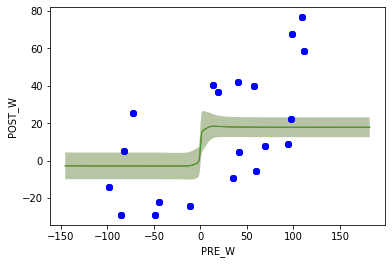

epoch: 7001 loss: 2665.17
epoch: 7002 loss: 5426.93125
epoch: 7003 loss: 53725.585
epoch: 7004 loss: 262827.62
epoch: 7005 loss: 110068.34
epoch: 7006 loss: 26498.9675
epoch: 7007 loss: 439770.8
epoch: 7008 loss: 272.1331640625
epoch: 7009 loss: 1156.554296875
epoch: 7010 loss: 3554.86125
epoch: 7011 loss: 11718.2525
epoch: 7012 loss: 280278.96
epoch: 7013 loss: 180930.76
epoch: 7014 loss: 142160.96
epoch: 7015 loss: 1249.813828125
epoch: 7016 loss: 9.738804321289063
epoch: 7017 loss: 4610.68
epoch: 7018 loss: 2209.70609375
epoch: 7019 loss: 167054.37
epoch: 7020 loss: 16726.02125
epoch: 7021 loss: 312384.04
epoch: 7022 loss: 188.99197265625
epoch: 7023 loss: 433.2385546875
epoch: 7024 loss: 5248.8575
epoch: 7025 loss: 18125.29875
epoch: 7026 loss: 20469.6425
epoch: 7027 loss: 78484.05
epoch: 7028 loss: 410833.36
epoch: 7029 loss: 4962.0325
epoch: 7030 loss: 3771.0378125
epoch: 7031 loss: 120874.84
epoch: 7032 loss: 299200.08
epoch: 7033 loss: 86459.69
epoch: 7034 loss: 4192.0540625
ep

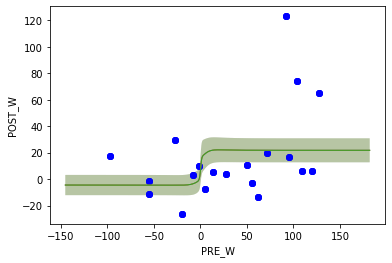

epoch: 8001 loss: 364.1858203125
epoch: 8002 loss: 6874.41875
epoch: 8003 loss: 25.26552490234375
epoch: 8004 loss: 12013.81
epoch: 8005 loss: 46829.29
epoch: 8006 loss: 12303.10875
epoch: 8007 loss: 104.3016796875
epoch: 8008 loss: 781.63390625
epoch: 8009 loss: 227.25259765625
epoch: 8010 loss: 36.50499755859375
epoch: 8011 loss: 1.7264569091796875
epoch: 8012 loss: 601.4316015625
epoch: 8013 loss: 8044.4075
epoch: 8014 loss: 189.47560546875
epoch: 8015 loss: 818.36625
epoch: 8016 loss: 50849.78
epoch: 8017 loss: 83.07064453125
epoch: 8018 loss: 88.7296875
epoch: 8019 loss: 966.711875
epoch: 8020 loss: 5708.455
epoch: 8021 loss: 26769.0825
epoch: 8022 loss: 73539.135
epoch: 8023 loss: 273562.5
epoch: 8024 loss: 37.3045458984375
epoch: 8025 loss: 24144.34
epoch: 8026 loss: 5432.860625
epoch: 8027 loss: 223316.12
epoch: 8028 loss: 9667.70625
epoch: 8029 loss: 345356.88
epoch: 8030 loss: 11115.70375
epoch: 8031 loss: 36.39597900390625
epoch: 8032 loss: 13.462359619140624
epoch: 8033 los

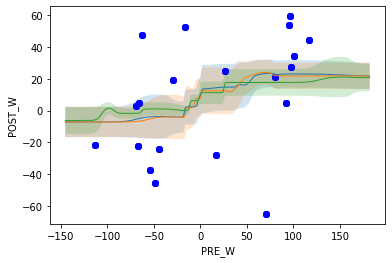

epoch: 9001 loss: 1.2365831756591796
epoch: 9002 loss: 1.8575874328613282
epoch: 9003 loss: 1.1020198059082031
epoch: 9004 loss: 0.6782823944091797
epoch: 9005 loss: 0.7212183380126953
epoch: 9006 loss: 1.4909503173828125
epoch: 9007 loss: 0.7000212860107422
epoch: 9008 loss: 0.6961965942382813
epoch: 9009 loss: 1.1881715393066405
epoch: 9010 loss: 0.8972158813476563
epoch: 9011 loss: 0.9355515289306641
epoch: 9012 loss: 1.0284061431884766
epoch: 9013 loss: 1.1491495513916015
epoch: 9014 loss: 0.861640853881836
epoch: 9015 loss: 1.1875233459472656
epoch: 9016 loss: 1.0859017181396484
epoch: 9017 loss: 0.8466775512695313
epoch: 9018 loss: 0.8953490447998047
epoch: 9019 loss: 0.805108413696289
epoch: 9020 loss: 0.7622672271728516
epoch: 9021 loss: 0.8511302947998047
epoch: 9022 loss: 1.1374272918701172
epoch: 9023 loss: 0.9767338562011719
epoch: 9024 loss: 0.58166748046875
epoch: 9025 loss: 1.0146990203857422
epoch: 9026 loss: 1.334449462890625
epoch: 9027 loss: 0.8550863647460938
epoch:

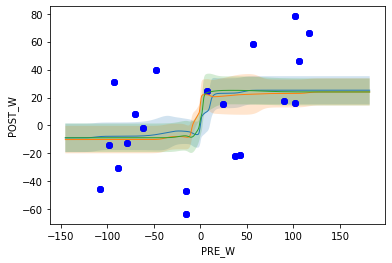

epoch: 10001 loss: 0.8494718933105468
epoch: 10002 loss: 0.8642671203613281
epoch: 10003 loss: 0.7090376281738281
epoch: 10004 loss: 0.7992279052734375
epoch: 10005 loss: 0.62632080078125
epoch: 10006 loss: 0.6733036041259766
epoch: 10007 loss: 0.7431659698486328
epoch: 10008 loss: 0.6323788452148438
epoch: 10009 loss: 0.724316635131836
epoch: 10010 loss: 0.76972412109375
epoch: 10011 loss: 0.9151203155517578
epoch: 10012 loss: 0.9923660278320312
epoch: 10013 loss: 0.5521947860717773
epoch: 10014 loss: 0.7046476745605469
epoch: 10015 loss: 0.8032803344726562
epoch: 10016 loss: 0.8928578186035157
epoch: 10017 loss: 0.8051475524902344
epoch: 10018 loss: 0.7171816253662109
epoch: 10019 loss: 0.7153266906738281
epoch: 10020 loss: 0.6262836837768555
epoch: 10021 loss: 0.7368171691894532
epoch: 10022 loss: 0.8738886260986328
epoch: 10023 loss: 0.6057902526855469
epoch: 10024 loss: 0.7938866424560547
epoch: 10025 loss: 0.7368625640869141
epoch: 10026 loss: 0.9102831268310547
epoch: 10027 loss

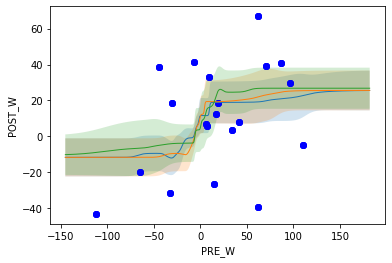

epoch: 11001 loss: 0.5634696197509765
epoch: 11002 loss: 0.6965373229980468
epoch: 11003 loss: 0.7039028930664063
epoch: 11004 loss: 0.6568393707275391
epoch: 11005 loss: 0.7616905212402344
epoch: 11006 loss: 0.8113054656982421
epoch: 11007 loss: 0.6416743469238281
epoch: 11008 loss: 0.7510250091552735
epoch: 11009 loss: 0.7141389465332031
epoch: 11010 loss: 0.6059214019775391
epoch: 11011 loss: 0.7668669128417969
epoch: 11012 loss: 0.6902676391601562
epoch: 11013 loss: 0.7817813110351562
epoch: 11014 loss: 0.6124999237060547
epoch: 11015 loss: 0.7244015502929687
epoch: 11016 loss: 0.7296922302246094
epoch: 11017 loss: 0.6836086273193359
epoch: 11018 loss: 0.6078363037109376
epoch: 11019 loss: 0.7373185729980469
epoch: 11020 loss: 0.4673348617553711
epoch: 11021 loss: 0.6971571350097656
epoch: 11022 loss: 0.6659048461914062
epoch: 11023 loss: 0.6538778686523438
epoch: 11024 loss: 0.68634521484375
epoch: 11025 loss: 0.7698690032958985
epoch: 11026 loss: 0.6955159759521484
epoch: 11027 l

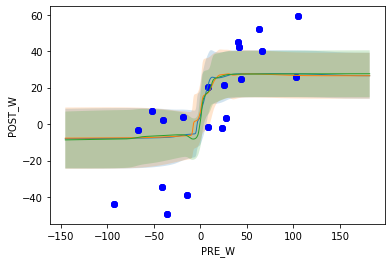

epoch: 12001 loss: 0.5978926086425781
epoch: 12002 loss: 0.6629953002929687
epoch: 12003 loss: 0.5388384246826172
epoch: 12004 loss: 0.5305184936523437
epoch: 12005 loss: 0.6096643447875977
epoch: 12006 loss: 0.7258763885498047
epoch: 12007 loss: 0.478776741027832
epoch: 12008 loss: 0.6514669799804688
epoch: 12009 loss: 0.6538651275634766
epoch: 12010 loss: 0.6144332504272461
epoch: 12011 loss: 0.6072874069213867
epoch: 12012 loss: 0.5061544799804687
epoch: 12013 loss: 0.5508343124389649
epoch: 12014 loss: 1.0325643157958984
epoch: 12015 loss: 0.781163330078125
epoch: 12016 loss: 0.6478089141845703
epoch: 12017 loss: 0.5500642013549805
epoch: 12018 loss: 0.5357329177856446
epoch: 12019 loss: 0.6064251708984375
epoch: 12020 loss: 0.5459606552124023
epoch: 12021 loss: 0.6227033615112305
epoch: 12022 loss: 0.5886246490478516
epoch: 12023 loss: 0.6751151275634766
epoch: 12024 loss: 0.6934001159667968
epoch: 12025 loss: 0.49584308624267576
epoch: 12026 loss: 0.5919655990600586
epoch: 12027 

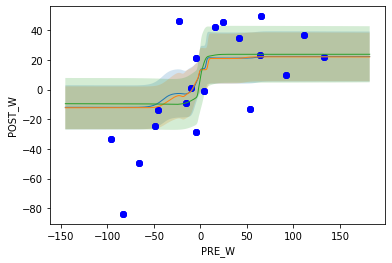

epoch: 13001 loss: 0.6343017959594727
epoch: 13002 loss: 0.49849906921386716
epoch: 13003 loss: 0.49348567962646483
epoch: 13004 loss: 0.5574906921386719
epoch: 13005 loss: 0.5720387268066406
epoch: 13006 loss: 0.5658028411865235
epoch: 13007 loss: 0.6150588989257812
epoch: 13008 loss: 0.5000740432739258
epoch: 13009 loss: 0.6596442413330078
epoch: 13010 loss: 0.5091838836669922
epoch: 13011 loss: 0.539613265991211
epoch: 13012 loss: 0.5192276763916016
epoch: 13013 loss: 0.49480438232421875
epoch: 13014 loss: 0.7749732971191406
epoch: 13015 loss: 0.596905174255371
epoch: 13016 loss: 0.551144905090332
epoch: 13017 loss: 0.6297456359863282
epoch: 13018 loss: 0.5026202392578125
epoch: 13019 loss: 0.4926742172241211
epoch: 13020 loss: 0.5210210418701172
epoch: 13021 loss: 0.6269686889648437
epoch: 13022 loss: 0.49610164642333987
epoch: 13023 loss: 0.5457066726684571
epoch: 13024 loss: 0.7212215423583984
epoch: 13025 loss: 0.523500633239746
epoch: 13026 loss: 0.5943949508666992
epoch: 13027

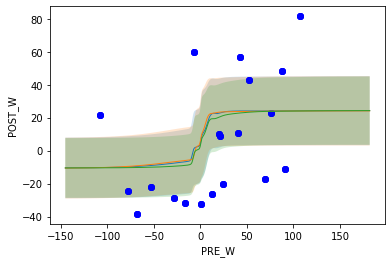

epoch: 14001 loss: 0.4959986114501953
epoch: 14002 loss: 0.4993537139892578
epoch: 14003 loss: 0.5837360763549805
epoch: 14004 loss: 0.5140864562988281
epoch: 14005 loss: 0.49635345458984376
epoch: 14006 loss: 0.4394219207763672
epoch: 14007 loss: 0.4910306549072266
epoch: 14008 loss: 0.6057521438598633
epoch: 14009 loss: 0.47967559814453126
epoch: 14010 loss: 0.5295246505737304
epoch: 14011 loss: 0.4616967010498047
epoch: 14012 loss: 0.5192378616333008
epoch: 14013 loss: 0.5032846450805664
epoch: 14014 loss: 0.5136265182495117
epoch: 14015 loss: 0.4986083984375
epoch: 14016 loss: 0.5235003280639648
epoch: 14017 loss: 0.5202782821655273
epoch: 14018 loss: 0.5035659790039062
epoch: 14019 loss: 0.5779792785644531
epoch: 14020 loss: 0.4820573806762695
epoch: 14021 loss: 0.4609380722045898
epoch: 14022 loss: 0.5029514312744141
epoch: 14023 loss: 0.5219918060302734
epoch: 14024 loss: 0.5081762313842774
epoch: 14025 loss: 0.4703662872314453
epoch: 14026 loss: 0.4886502456665039
epoch: 14027 

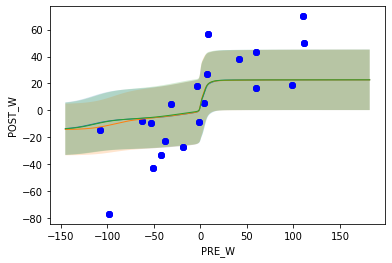

epoch: 15001 loss: 0.49007961273193357
epoch: 15002 loss: 0.5286182403564453
epoch: 15003 loss: 0.4969794464111328
epoch: 15004 loss: 0.5273479461669922
epoch: 15005 loss: 0.45982688903808594
epoch: 15006 loss: 0.5343487167358398
epoch: 15007 loss: 0.4799163818359375
epoch: 15008 loss: 0.4994371795654297
epoch: 15009 loss: 0.5185618209838867
epoch: 15010 loss: 0.4853969192504883
epoch: 15011 loss: 0.44138671875
epoch: 15012 loss: 0.5240295791625976
epoch: 15013 loss: 0.4951516342163086
epoch: 15014 loss: 0.5343317794799805
epoch: 15015 loss: 0.46607250213623047
epoch: 15016 loss: 0.4772964096069336
epoch: 15017 loss: 0.5226194381713867
epoch: 15018 loss: 0.4791683578491211
epoch: 15019 loss: 0.4956318664550781
epoch: 15020 loss: 0.4993502807617187
epoch: 15021 loss: 0.4883296203613281
epoch: 15022 loss: 0.4809363555908203
epoch: 15023 loss: 0.45518714904785157
epoch: 15024 loss: 0.49093391418457033
epoch: 15025 loss: 0.47504749298095705
epoch: 15026 loss: 0.5368777847290039
epoch: 1502

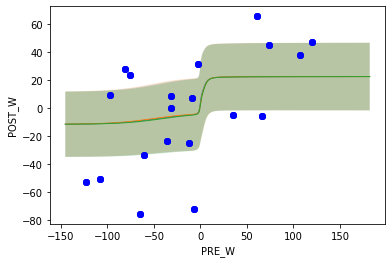

epoch: 16001 loss: 0.467861213684082
epoch: 16002 loss: 0.479776611328125
epoch: 16003 loss: 0.5789152145385742
epoch: 16004 loss: 0.4458825302124023
epoch: 16005 loss: 0.5342728424072266
epoch: 16006 loss: 0.49752346038818357
epoch: 16007 loss: 0.5449683380126953
epoch: 16008 loss: 0.49759750366210936
epoch: 16009 loss: 0.481678466796875
epoch: 16010 loss: 0.5037148666381835
epoch: 16011 loss: 0.47439666748046877
epoch: 16012 loss: 0.49522727966308594
epoch: 16013 loss: 0.5265070724487305
epoch: 16014 loss: 0.474880256652832
epoch: 16015 loss: 0.5758435440063476
epoch: 16016 loss: 0.4772834777832031
epoch: 16017 loss: 0.48394309997558593
epoch: 16018 loss: 0.48833866119384767
epoch: 16019 loss: 0.47094375610351563
epoch: 16020 loss: 0.5307583236694335
epoch: 16021 loss: 0.48727535247802733
epoch: 16022 loss: 0.4885059356689453
epoch: 16023 loss: 0.49707366943359377
epoch: 16024 loss: 0.48541378021240233
epoch: 16025 loss: 0.4887539291381836
epoch: 16026 loss: 0.4889334487915039
epoch:

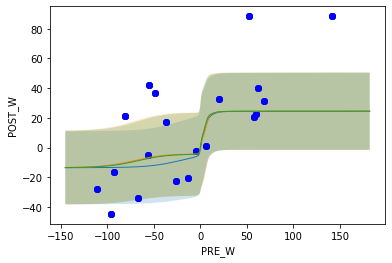

epoch: 17001 loss: 0.48557445526123044
epoch: 17002 loss: 0.4430370330810547
epoch: 17003 loss: 0.5019593048095703
epoch: 17004 loss: 0.4861199569702148
epoch: 17005 loss: 0.47714656829833985
epoch: 17006 loss: 0.4546371078491211
epoch: 17007 loss: 0.47594154357910157
epoch: 17008 loss: 0.4692403793334961
epoch: 17009 loss: 0.49470264434814454
epoch: 17010 loss: 0.4677229690551758
epoch: 17011 loss: 0.5708272933959961
epoch: 17012 loss: 0.47538082122802733
epoch: 17013 loss: 0.47346351623535154
epoch: 17014 loss: 0.472641716003418
epoch: 17015 loss: 0.5016856765747071
epoch: 17016 loss: 0.5171865844726562
epoch: 17017 loss: 0.4731412887573242
epoch: 17018 loss: 0.4526487731933594
epoch: 17019 loss: 0.4781460189819336
epoch: 17020 loss: 0.5262535095214844
epoch: 17021 loss: 0.47203857421875
epoch: 17022 loss: 0.4904771423339844
epoch: 17023 loss: 0.49899993896484374
epoch: 17024 loss: 0.46885425567626954
epoch: 17025 loss: 0.4740113067626953
epoch: 17026 loss: 0.4886962890625
epoch: 170

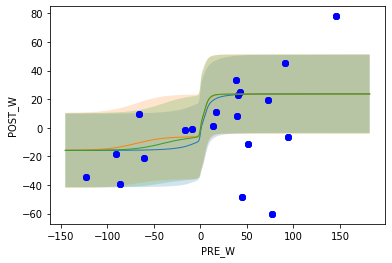

epoch: 18001 loss: 0.4660286712646484
epoch: 18002 loss: 0.4964763641357422
epoch: 18003 loss: 0.48848102569580076
epoch: 18004 loss: 0.5095519638061523
epoch: 18005 loss: 0.5139994812011719
epoch: 18006 loss: 0.4638615417480469
epoch: 18007 loss: 0.46778289794921873
epoch: 18008 loss: 0.4945235824584961
epoch: 18009 loss: 0.45508411407470706
epoch: 18010 loss: 0.4909345626831055
epoch: 18011 loss: 0.49686786651611325
epoch: 18012 loss: 0.5016175842285157
epoch: 18013 loss: 0.4763027191162109
epoch: 18014 loss: 0.49698474884033206
epoch: 18015 loss: 0.5050953292846679
epoch: 18016 loss: 0.4675279235839844
epoch: 18017 loss: 0.5149776077270508
epoch: 18018 loss: 0.5592892837524414
epoch: 18019 loss: 0.5234627151489257
epoch: 18020 loss: 0.4599607467651367
epoch: 18021 loss: 0.45586429595947264
epoch: 18022 loss: 0.520682487487793
epoch: 18023 loss: 0.47709178924560547
epoch: 18024 loss: 0.4687035369873047
epoch: 18025 loss: 0.4747679901123047
epoch: 18026 loss: 0.5142650985717774
epoch:

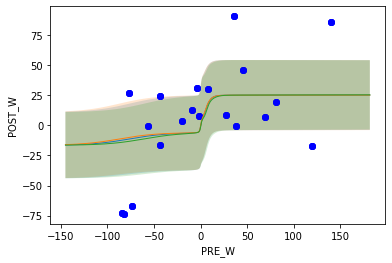

epoch: 19001 loss: 0.46368812561035155
epoch: 19002 loss: 0.49927356719970706
epoch: 19003 loss: 0.4774161911010742
epoch: 19004 loss: 0.4600245666503906
epoch: 19005 loss: 0.45712718963623045
epoch: 19006 loss: 0.47372711181640625
epoch: 19007 loss: 0.470220947265625
epoch: 19008 loss: 0.4630987930297852
epoch: 19009 loss: 0.47011943817138674
epoch: 19010 loss: 0.4671790313720703
epoch: 19011 loss: 0.46261474609375
epoch: 19012 loss: 0.49181766510009767
epoch: 19013 loss: 0.5060417175292968
epoch: 19014 loss: 0.5851432800292968
epoch: 19015 loss: 0.4739715194702148
epoch: 19016 loss: 0.4853266906738281
epoch: 19017 loss: 0.4733321762084961
epoch: 19018 loss: 0.5030607223510742
epoch: 19019 loss: 0.48944103240966796
epoch: 19020 loss: 0.5497142410278321
epoch: 19021 loss: 0.4999619674682617
epoch: 19022 loss: 0.48259212493896486
epoch: 19023 loss: 0.49840847015380857
epoch: 19024 loss: 0.4727317428588867
epoch: 19025 loss: 0.46850536346435545
epoch: 19026 loss: 0.49091693878173825
epoc

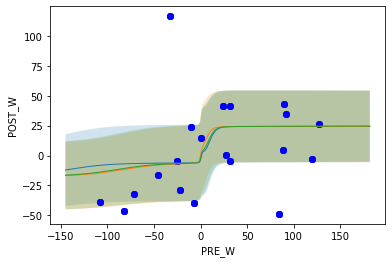

epoch: 20001 loss: 0.5214669799804688
epoch: 20002 loss: 0.49485149383544924
epoch: 20003 loss: 0.4679312896728516
epoch: 20004 loss: 0.48066699981689454
epoch: 20005 loss: 0.4854620361328125
epoch: 20006 loss: 0.48662776947021485
epoch: 20007 loss: 0.47693260192871095
epoch: 20008 loss: 0.46376670837402345
epoch: 20009 loss: 0.4669285583496094
epoch: 20010 loss: 0.4726133346557617
epoch: 20011 loss: 0.46492145538330076
epoch: 20012 loss: 0.4822212219238281
epoch: 20013 loss: 0.4949226379394531
epoch: 20014 loss: 0.4657851028442383
epoch: 20015 loss: 0.5055743789672852
epoch: 20016 loss: 0.4630878448486328
epoch: 20017 loss: 0.4608108901977539
epoch: 20018 loss: 0.5019293212890625
epoch: 20019 loss: 0.49327693939208983
epoch: 20020 loss: 0.4661215591430664
epoch: 20021 loss: 0.46762790679931643
epoch: 20022 loss: 0.4595734405517578
epoch: 20023 loss: 0.48672821044921877
epoch: 20024 loss: 0.4687569046020508
epoch: 20025 loss: 0.472559814453125
epoch: 20026 loss: 0.4782563781738281
epoc

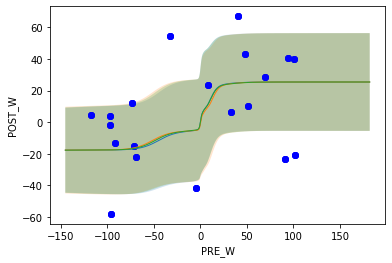

epoch: 21001 loss: 0.49001617431640626
epoch: 21002 loss: 0.4728409194946289
epoch: 21003 loss: 0.478702507019043
epoch: 21004 loss: 0.48064628601074216
epoch: 21005 loss: 0.46963253021240237
epoch: 21006 loss: 0.4970571517944336
epoch: 21007 loss: 0.485391731262207
epoch: 21008 loss: 0.5234111022949218
epoch: 21009 loss: 0.48661495208740235
epoch: 21010 loss: 0.5088166046142578
epoch: 21011 loss: 0.4809120559692383
epoch: 21012 loss: 0.46497886657714843
epoch: 21013 loss: 0.5006999588012695
epoch: 21014 loss: 0.499503173828125
epoch: 21015 loss: 0.495177116394043
epoch: 21016 loss: 0.4644841003417969
epoch: 21017 loss: 0.47341346740722656
epoch: 21018 loss: 0.4646683502197266
epoch: 21019 loss: 0.470120849609375
epoch: 21020 loss: 0.5104030990600585
epoch: 21021 loss: 0.47898136138916014
epoch: 21022 loss: 0.5235692977905273
epoch: 21023 loss: 0.4853875350952148
epoch: 21024 loss: 0.5266839981079101
epoch: 21025 loss: 0.4883984375
epoch: 21026 loss: 0.47378299713134764
epoch: 21027 lo

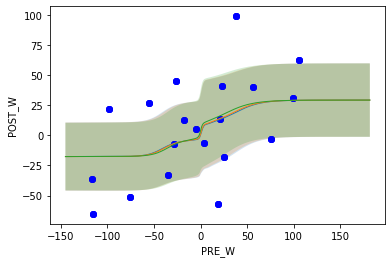

epoch: 22001 loss: 0.5040629196166992
epoch: 22002 loss: 0.47583732604980467
epoch: 22003 loss: 0.49114288330078126
epoch: 22004 loss: 0.48923793792724607
epoch: 22005 loss: 0.4592226791381836
epoch: 22006 loss: 0.4844265365600586
epoch: 22007 loss: 0.49122032165527346
epoch: 22008 loss: 0.5001932144165039
epoch: 22009 loss: 0.4765958023071289
epoch: 22010 loss: 0.49569145202636716
epoch: 22011 loss: 0.4484603118896484
epoch: 22012 loss: 0.49569339752197267
epoch: 22013 loss: 0.4824243927001953
epoch: 22014 loss: 0.480042724609375
epoch: 22015 loss: 0.4640616226196289
epoch: 22016 loss: 0.4796886825561523
epoch: 22017 loss: 0.5215058898925782
epoch: 22018 loss: 0.4760552215576172
epoch: 22019 loss: 0.4760234832763672
epoch: 22020 loss: 0.4623063278198242
epoch: 22021 loss: 0.5033259963989258
epoch: 22022 loss: 0.5015667724609375
epoch: 22023 loss: 0.49132957458496096
epoch: 22024 loss: 0.47725189208984375
epoch: 22025 loss: 0.4618939208984375
epoch: 22026 loss: 0.47271625518798827
epoc

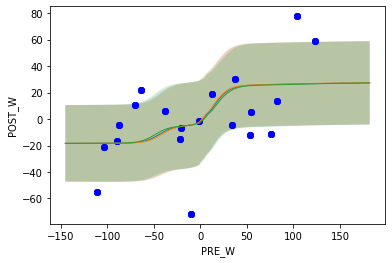

epoch: 23001 loss: 0.4838563537597656
epoch: 23002 loss: 0.4801169967651367
epoch: 23003 loss: 0.5365643692016602
epoch: 23004 loss: 0.47652366638183596
epoch: 23005 loss: 0.46972782135009766
epoch: 23006 loss: 0.4903479766845703
epoch: 23007 loss: 0.4713784790039062
epoch: 23008 loss: 0.46542011260986327
epoch: 23009 loss: 0.484599609375
epoch: 23010 loss: 0.477781867980957
epoch: 23011 loss: 0.49834083557128905
epoch: 23012 loss: 0.5094917678833008
epoch: 23013 loss: 0.46783119201660156
epoch: 23014 loss: 0.47861122131347655
epoch: 23015 loss: 0.5111352920532226
epoch: 23016 loss: 0.46575782775878904
epoch: 23017 loss: 0.47021945953369143
epoch: 23018 loss: 0.4951275634765625
epoch: 23019 loss: 0.512607192993164
epoch: 23020 loss: 0.49262950897216795
epoch: 23021 loss: 0.5020927047729492
epoch: 23022 loss: 0.4950580596923828
epoch: 23023 loss: 0.5153966903686523
epoch: 23024 loss: 0.4565742111206055
epoch: 23025 loss: 0.4790951919555664
epoch: 23026 loss: 0.4758877182006836
epoch: 23

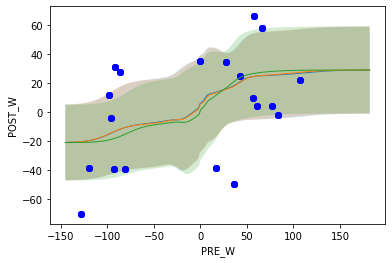

epoch: 24001 loss: 0.5204680633544921
epoch: 24002 loss: 0.4704301834106445
epoch: 24003 loss: 0.5053339004516602
epoch: 24004 loss: 0.4632893753051758
epoch: 24005 loss: 0.49144203186035157
epoch: 24006 loss: 0.46263828277587893
epoch: 24007 loss: 0.5260869598388672
epoch: 24008 loss: 0.4820100784301758
epoch: 24009 loss: 0.4839942932128906
epoch: 24010 loss: 0.48640090942382813
epoch: 24011 loss: 0.48793136596679687
epoch: 24012 loss: 0.46316329956054686
epoch: 24013 loss: 0.46628116607666015
epoch: 24014 loss: 0.5190627670288086
epoch: 24015 loss: 0.4882614517211914
epoch: 24016 loss: 0.5111061096191406
epoch: 24017 loss: 0.452841796875
epoch: 24018 loss: 0.470333366394043
epoch: 24019 loss: 0.5008626174926758
epoch: 24020 loss: 0.4904302215576172
epoch: 24021 loss: 0.46095909118652345
epoch: 24022 loss: 0.46657730102539063
epoch: 24023 loss: 0.45932411193847655
epoch: 24024 loss: 0.46971611022949217
epoch: 24025 loss: 0.49062747955322267
epoch: 24026 loss: 0.47512962341308596
epoch

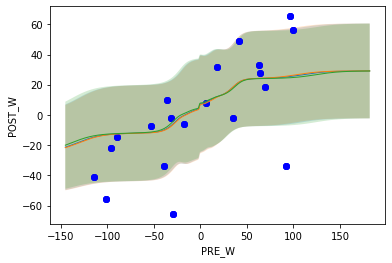

epoch: 25001 loss: 0.46513153076171876
epoch: 25002 loss: 0.4714216232299805
epoch: 25003 loss: 0.4854943466186523
epoch: 25004 loss: 0.4593793487548828
epoch: 25005 loss: 0.47806228637695314
epoch: 25006 loss: 0.47874629974365235
epoch: 25007 loss: 0.5067682647705078
epoch: 25008 loss: 0.45923355102539065
epoch: 25009 loss: 0.520771598815918
epoch: 25010 loss: 0.4922745513916016
epoch: 25011 loss: 0.4815703964233398
epoch: 25012 loss: 0.4769982147216797
epoch: 25013 loss: 0.4716032028198242
epoch: 25014 loss: 0.4681645584106445
epoch: 25015 loss: 0.4479827880859375
epoch: 25016 loss: 0.4587508010864258
epoch: 25017 loss: 0.4724983978271484
epoch: 25018 loss: 0.48332088470458984
epoch: 25019 loss: 0.4726006317138672
epoch: 25020 loss: 0.4824016571044922
epoch: 25021 loss: 0.4776520538330078
epoch: 25022 loss: 0.49349174499511717
epoch: 25023 loss: 0.4783383560180664
epoch: 25024 loss: 0.5562054824829101
epoch: 25025 loss: 0.46152774810791014
epoch: 25026 loss: 0.4697539138793945
epoch:

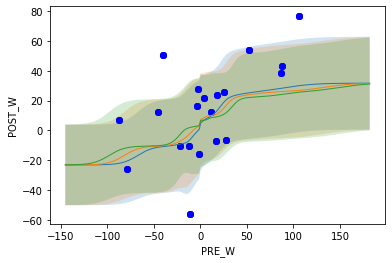

epoch: 26001 loss: 0.4973762512207031
epoch: 26002 loss: 0.4952059173583984
epoch: 26003 loss: 0.5124577713012696
epoch: 26004 loss: 0.5029617309570312
epoch: 26005 loss: 0.4526732635498047
epoch: 26006 loss: 0.4795713424682617
epoch: 26007 loss: 0.494157600402832
epoch: 26008 loss: 0.47028656005859376
epoch: 26009 loss: 0.4919472885131836
epoch: 26010 loss: 0.497224006652832
epoch: 26011 loss: 0.5432767868041992
epoch: 26012 loss: 0.4976948165893555
epoch: 26013 loss: 0.4775264358520508
epoch: 26014 loss: 0.47606788635253905
epoch: 26015 loss: 0.47886558532714846
epoch: 26016 loss: 0.4673778533935547
epoch: 26017 loss: 0.4979447555541992
epoch: 26018 loss: 0.49028453826904295
epoch: 26019 loss: 0.48478260040283205
epoch: 26020 loss: 0.47608642578125
epoch: 26021 loss: 0.5115383529663086
epoch: 26022 loss: 0.5565303421020508
epoch: 26023 loss: 0.47968009948730467
epoch: 26024 loss: 0.5272739410400391
epoch: 26025 loss: 0.4856108093261719
epoch: 26026 loss: 0.48561103820800783
epoch: 26

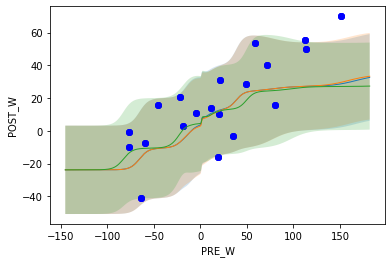

epoch: 27001 loss: 0.4827455139160156
epoch: 27002 loss: 0.5067296981811523
epoch: 27003 loss: 0.48106861114501953
epoch: 27004 loss: 0.5276150512695312
epoch: 27005 loss: 0.4735882568359375
epoch: 27006 loss: 0.4805931091308594
epoch: 27007 loss: 0.5274615478515625
epoch: 27008 loss: 0.46350257873535156
epoch: 27009 loss: 0.5898562240600586
epoch: 27010 loss: 0.467759895324707
epoch: 27011 loss: 0.48804550170898436
epoch: 27012 loss: 0.47313446044921875
epoch: 27013 loss: 0.4930595016479492
epoch: 27014 loss: 0.4602082443237305
epoch: 27015 loss: 0.5030360412597656
epoch: 27016 loss: 0.483916015625
epoch: 27017 loss: 0.44801811218261717
epoch: 27018 loss: 0.4832792282104492
epoch: 27019 loss: 0.4808968734741211
epoch: 27020 loss: 0.4870354461669922
epoch: 27021 loss: 0.4547981643676758
epoch: 27022 loss: 0.4780354690551758
epoch: 27023 loss: 0.48092433929443357
epoch: 27024 loss: 0.4635931396484375
epoch: 27025 loss: 0.48059051513671874
epoch: 27026 loss: 0.4925569534301758
epoch: 270

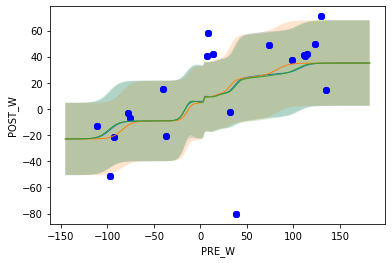

epoch: 28001 loss: 0.5175170516967773
epoch: 28002 loss: 0.4784031295776367
epoch: 28003 loss: 0.47931724548339844
epoch: 28004 loss: 0.47117393493652343
epoch: 28005 loss: 0.5208629608154297
epoch: 28006 loss: 0.4797884750366211
epoch: 28007 loss: 0.47857860565185545
epoch: 28008 loss: 0.47334053039550783
epoch: 28009 loss: 0.47400741577148436
epoch: 28010 loss: 0.4909792327880859
epoch: 28011 loss: 0.482281379699707
epoch: 28012 loss: 0.46777313232421874
epoch: 28013 loss: 0.5768927764892579
epoch: 28014 loss: 0.5323531723022461
epoch: 28015 loss: 0.4894858169555664
epoch: 28016 loss: 0.469208984375
epoch: 28017 loss: 0.47783355712890624
epoch: 28018 loss: 0.4730337142944336
epoch: 28019 loss: 0.48976932525634764
epoch: 28020 loss: 0.48412979125976563
epoch: 28021 loss: 0.4784553146362305
epoch: 28022 loss: 0.4522371292114258
epoch: 28023 loss: 0.49866107940673826
epoch: 28024 loss: 0.49268856048583987
epoch: 28025 loss: 0.5061935806274414
epoch: 28026 loss: 0.5072518157958984
epoch:

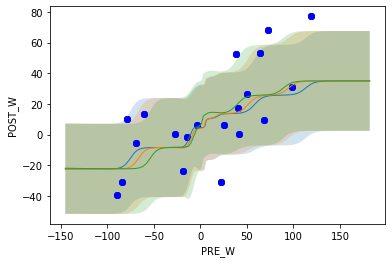

epoch: 29001 loss: 0.5198251724243164
epoch: 29002 loss: 0.4909380340576172
epoch: 29003 loss: 0.45317909240722654
epoch: 29004 loss: 0.4865085983276367
epoch: 29005 loss: 0.5005869674682617
epoch: 29006 loss: 0.47333301544189454
epoch: 29007 loss: 0.47584754943847657
epoch: 29008 loss: 0.4864101791381836
epoch: 29009 loss: 0.4761961364746094
epoch: 29010 loss: 0.46709030151367187
epoch: 29011 loss: 0.44968994140625
epoch: 29012 loss: 0.512662467956543
epoch: 29013 loss: 0.45873504638671875
epoch: 29014 loss: 0.46299209594726565
epoch: 29015 loss: 0.4832014083862305
epoch: 29016 loss: 0.4705714797973633
epoch: 29017 loss: 0.47128795623779296
epoch: 29018 loss: 0.467894172668457
epoch: 29019 loss: 0.486939697265625
epoch: 29020 loss: 0.5114889144897461
epoch: 29021 loss: 0.46666305541992187
epoch: 29022 loss: 0.5249370956420898
epoch: 29023 loss: 0.49324424743652345
epoch: 29024 loss: 0.49306503295898435
epoch: 29025 loss: 0.45063720703125
epoch: 29026 loss: 0.4841560745239258
epoch: 29

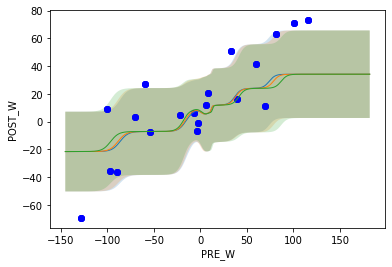

epoch: 30001 loss: 0.47655563354492186
epoch: 30002 loss: 0.48547801971435545
epoch: 30003 loss: 0.504640121459961
epoch: 30004 loss: 0.48177997589111327
epoch: 30005 loss: 0.6667319488525391
epoch: 30006 loss: 0.46945838928222655
epoch: 30007 loss: 0.4735641860961914
epoch: 30008 loss: 0.4894025421142578
epoch: 30009 loss: 0.47019229888916014
epoch: 30010 loss: 0.49171295166015627
epoch: 30011 loss: 0.4738600158691406
epoch: 30012 loss: 0.46895641326904297
epoch: 30013 loss: 0.5109040832519531
epoch: 30014 loss: 0.4657892227172852
epoch: 30015 loss: 0.4674483108520508
epoch: 30016 loss: 0.524970703125
epoch: 30017 loss: 0.4817607879638672
epoch: 30018 loss: 0.4978423309326172
epoch: 30019 loss: 0.4648497772216797
epoch: 30020 loss: 0.4882656097412109
epoch: 30021 loss: 0.5016350936889649
epoch: 30022 loss: 0.4796042251586914
epoch: 30023 loss: 0.46406696319580076
epoch: 30024 loss: 0.4535892105102539
epoch: 30025 loss: 0.47483158111572266
epoch: 30026 loss: 0.515170783996582
epoch: 30

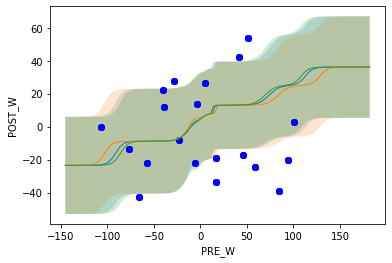

epoch: 31001 loss: 0.47448345184326174
epoch: 31002 loss: 0.4908963394165039
epoch: 31003 loss: 0.4850993347167969
epoch: 31004 loss: 0.4876233673095703
epoch: 31005 loss: 0.4941737747192383
epoch: 31006 loss: 0.5007426071166993
epoch: 31007 loss: 0.4769623947143555
epoch: 31008 loss: 0.48175880432128904
epoch: 31009 loss: 0.46811485290527344
epoch: 31010 loss: 0.48659454345703124
epoch: 31011 loss: 0.5103542709350586
epoch: 31012 loss: 0.47453460693359373
epoch: 31013 loss: 0.47311408996582033
epoch: 31014 loss: 0.4851540756225586
epoch: 31015 loss: 0.4745337677001953
epoch: 31016 loss: 0.47229656219482424
epoch: 31017 loss: 0.4675762176513672
epoch: 31018 loss: 0.4734200668334961
epoch: 31019 loss: 0.4844582748413086
epoch: 31020 loss: 0.48726768493652345
epoch: 31021 loss: 0.4821219635009766
epoch: 31022 loss: 0.4746634292602539
epoch: 31023 loss: 0.49864997863769533
epoch: 31024 loss: 0.4869356536865234
epoch: 31025 loss: 0.5339389038085938
epoch: 31026 loss: 0.4827428817749023
epo

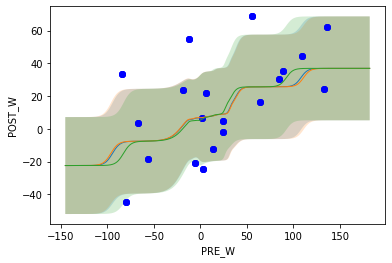

epoch: 32001 loss: 0.4807449722290039
epoch: 32002 loss: 0.5139034271240235
epoch: 32003 loss: 0.4923251724243164
epoch: 32004 loss: 0.48094600677490235
epoch: 32005 loss: 0.4621738433837891
epoch: 32006 loss: 0.495599365234375
epoch: 32007 loss: 0.5097621536254883
epoch: 32008 loss: 0.49243717193603515
epoch: 32009 loss: 0.4712907028198242
epoch: 32010 loss: 0.49296276092529295
epoch: 32011 loss: 0.5035568237304687
epoch: 32012 loss: 0.4782999801635742
epoch: 32013 loss: 0.4669281005859375
epoch: 32014 loss: 0.4789518737792969
epoch: 32015 loss: 0.5002756118774414
epoch: 32016 loss: 0.47898475646972655
epoch: 32017 loss: 0.46865081787109375
epoch: 32018 loss: 0.48987464904785155
epoch: 32019 loss: 0.4718454742431641
epoch: 32020 loss: 0.4733559036254883
epoch: 32021 loss: 0.48328800201416017
epoch: 32022 loss: 0.4683325958251953
epoch: 32023 loss: 0.4842998123168945
epoch: 32024 loss: 0.49577098846435547
epoch: 32025 loss: 0.49792701721191407
epoch: 32026 loss: 0.5023855972290039
epoc

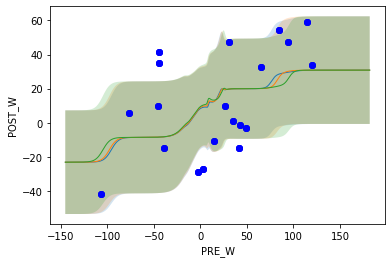

epoch: 33001 loss: 0.46262489318847655
epoch: 33002 loss: 0.478430290222168
epoch: 33003 loss: 0.4825650405883789
epoch: 33004 loss: 0.4888010025024414
epoch: 33005 loss: 0.48829605102539064
epoch: 33006 loss: 0.5050642395019531
epoch: 33007 loss: 0.46702568054199217
epoch: 33008 loss: 0.4838869094848633
epoch: 33009 loss: 0.46082576751708987
epoch: 33010 loss: 0.4869196701049805
epoch: 33011 loss: 0.5145963287353515
epoch: 33012 loss: 0.5127599334716797
epoch: 33013 loss: 0.4592855453491211
epoch: 33014 loss: 0.5448931503295898
epoch: 33015 loss: 0.48505687713623047
epoch: 33016 loss: 0.48254737854003904
epoch: 33017 loss: 0.4779477310180664
epoch: 33018 loss: 0.5212483978271485
epoch: 33019 loss: 0.46167964935302735
epoch: 33020 loss: 0.4898223876953125
epoch: 33021 loss: 0.47423179626464845
epoch: 33022 loss: 0.4709709930419922
epoch: 33023 loss: 0.4739186096191406
epoch: 33024 loss: 0.47598411560058596
epoch: 33025 loss: 0.4649399948120117
epoch: 33026 loss: 0.48264671325683595
epo

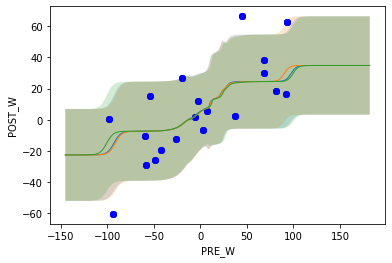

epoch: 34001 loss: 0.485915412902832
epoch: 34002 loss: 0.47235897064208987
epoch: 34003 loss: 0.489821662902832
epoch: 34004 loss: 0.4689971542358398
epoch: 34005 loss: 0.5160009765625
epoch: 34006 loss: 0.46230087280273435
epoch: 34007 loss: 0.47690921783447265
epoch: 34008 loss: 0.4797487640380859
epoch: 34009 loss: 0.47601421356201173
epoch: 34010 loss: 0.49511032104492186
epoch: 34011 loss: 0.4901298522949219
epoch: 34012 loss: 0.5186428833007812
epoch: 34013 loss: 0.4598160552978516
epoch: 34014 loss: 0.5000308227539062
epoch: 34015 loss: 0.47431896209716795
epoch: 34016 loss: 0.4659169387817383
epoch: 34017 loss: 0.48636722564697266
epoch: 34018 loss: 0.49532657623291015
epoch: 34019 loss: 0.47302200317382814
epoch: 34020 loss: 0.4893380355834961
epoch: 34021 loss: 0.47078689575195315
epoch: 34022 loss: 0.5335464859008789
epoch: 34023 loss: 0.49772369384765625
epoch: 34024 loss: 0.4781746292114258
epoch: 34025 loss: 0.5002567672729492
epoch: 34026 loss: 0.49462501525878905
epoch

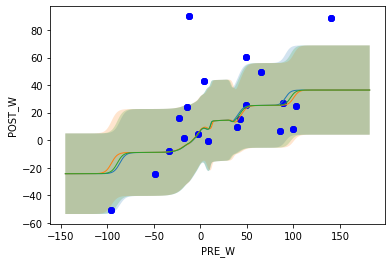

epoch: 35001 loss: 0.4759261703491211
epoch: 35002 loss: 0.45759479522705077
epoch: 35003 loss: 0.4640015029907227
epoch: 35004 loss: 0.5274934387207031
epoch: 35005 loss: 0.47543098449707033
epoch: 35006 loss: 0.504959831237793
epoch: 35007 loss: 0.4782757568359375
epoch: 35008 loss: 0.4784540557861328
epoch: 35009 loss: 0.4591381072998047
epoch: 35010 loss: 0.48379825592041015
epoch: 35011 loss: 0.487271728515625
epoch: 35012 loss: 0.47650363922119143
epoch: 35013 loss: 0.4921828079223633
epoch: 35014 loss: 0.4739605712890625
epoch: 35015 loss: 0.5024476623535157
epoch: 35016 loss: 0.46281200408935547
epoch: 35017 loss: 0.48444046020507814
epoch: 35018 loss: 0.4887629318237305
epoch: 35019 loss: 0.5353635025024414
epoch: 35020 loss: 0.47248626708984376
epoch: 35021 loss: 0.5064879989624024
epoch: 35022 loss: 0.4853129577636719
epoch: 35023 loss: 0.4701364898681641
epoch: 35024 loss: 0.4833926010131836
epoch: 35025 loss: 0.4882158660888672
epoch: 35026 loss: 0.47298389434814453
epoch:

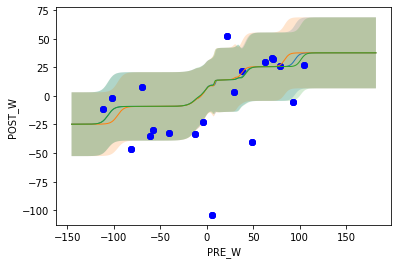

epoch: 36001 loss: 0.5473286056518555
epoch: 36002 loss: 0.47421314239501955
epoch: 36003 loss: 0.46413875579833985
epoch: 36004 loss: 0.48086105346679686
epoch: 36005 loss: 0.44727420806884766
epoch: 36006 loss: 0.4688620758056641
epoch: 36007 loss: 0.472611198425293
epoch: 36008 loss: 0.4704009246826172
epoch: 36009 loss: 0.4813411712646484
epoch: 36010 loss: 0.4734502792358398
epoch: 36011 loss: 0.49581241607666016
epoch: 36012 loss: 0.5007662200927734
epoch: 36013 loss: 0.4816979217529297
epoch: 36014 loss: 0.4530854415893555
epoch: 36015 loss: 0.4679093933105469
epoch: 36016 loss: 0.46309635162353513
epoch: 36017 loss: 0.48341854095458986
epoch: 36018 loss: 0.48418357849121096
epoch: 36019 loss: 0.4888490295410156
epoch: 36020 loss: 0.4807001495361328
epoch: 36021 loss: 0.46934707641601564
epoch: 36022 loss: 0.5288298416137696
epoch: 36023 loss: 0.47687545776367185
epoch: 36024 loss: 0.48351245880126953
epoch: 36025 loss: 0.4626846694946289
epoch: 36026 loss: 0.542650146484375
epo

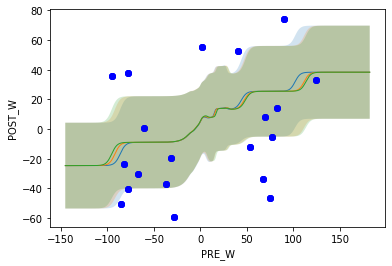

epoch: 37001 loss: 0.6007843017578125
epoch: 37002 loss: 0.5119240951538085
epoch: 37003 loss: 0.4674468231201172
epoch: 37004 loss: 0.4939722442626953
epoch: 37005 loss: 0.5426337051391602
epoch: 37006 loss: 0.48476829528808596
epoch: 37007 loss: 0.4744321060180664
epoch: 37008 loss: 0.48725334167480466
epoch: 37009 loss: 0.505582618713379
epoch: 37010 loss: 0.4666858673095703
epoch: 37011 loss: 0.4770063018798828
epoch: 37012 loss: 0.4699822235107422
epoch: 37013 loss: 0.5028468322753906
epoch: 37014 loss: 0.46983821868896486
epoch: 37015 loss: 0.485889892578125
epoch: 37016 loss: 0.5143815612792969
epoch: 37017 loss: 0.47461906433105466
epoch: 37018 loss: 0.4771863555908203
epoch: 37019 loss: 0.4618124771118164
epoch: 37020 loss: 0.5128765487670899
epoch: 37021 loss: 0.5139520645141602
epoch: 37022 loss: 0.5022638702392578
epoch: 37023 loss: 0.5018905258178711
epoch: 37024 loss: 0.4868955230712891
epoch: 37025 loss: 0.4869977569580078
epoch: 37026 loss: 0.4866362762451172
epoch: 370

KeyboardInterrupt: ignored

In [28]:
# prepare input data (defined in cell above)
def train(epochs, n_context):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        # split into 
        x_context, y_context, x_target, y_target = random_split_context_target(all_x_np, all_y_np, n_context)
        # send to gpu
        x_context = torch.from_numpy(x_context).to(device)
        y_context = torch.from_numpy(y_context).to(device)
        x_target = torch.from_numpy(x_target).to(device)
        y_target = torch.from_numpy(y_target).to(device)
        # forward pass
        mu, std, z_mean_all, z_std_all, z_mean, z_std = model(x_context, y_context, x_target, y_target)
        # loss calculation
        loss = -log_likelihood(mu, std, y_context) + KLD_gaussian(z_mean_all, z_std_all, z_mean, z_std)
        # backprop
        loss.backward()
        training_loss = loss.item()
        optimizer.step()
        print('epoch: {} loss: {}'.format(epoch, training_loss/200))

        # save figure at every 100th training epoch
        if epoch % 1000 == 0:
            visualize(x_context, y_context, torch.from_numpy(vals.reshape(-1, 1).astype(np.float32)).to(device), \
                      model, epoch, xvar, yvar)
        
        # test with target points
        # TODO

''' data example
    parttype, xvar, yvar = 'R0402', 'PRE_L', 'POST_L'
    all_x_np = chip_dataframes[parttype][xvar].values[0:-1].reshape(-1, 1).astype(np.float32)
    all_y_np = chip_dataframes[parttype][yvar].values[0:-1].reshape(-1, 1).astype(np.float32)
'''
vals = np.arange(min(all_x_np), max(all_x_np), 1e-3)
x_grid = torch.from_numpy(vals.reshape(-1, 1).astype(np.float32))

hidden_dim , decoder_dim, z_samples = 10, 15, 20 # 10, 15, 20
model = NP(hidden_dim , decoder_dim, z_samples).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
# n_context = np.random.randint(20, 30) # a random number between the two numbers
n_context = 20
train(10**5, n_context)

